Upload your dataset file:


Saving Data.xlsx to Data.xlsx
Dataset Overview:
  Warehouse id Region SKU id      Month  Sales
0         Wh-1  NORTH  SKU-1 2018-04-01     27
1         Wh-1  NORTH  SKU-2 2018-04-01     88
2         Wh-1  NORTH  SKU-3 2018-04-01      6
3         Wh-1  NORTH  SKU-4 2018-04-01    162
4         Wh-1  NORTH  SKU-5 2018-04-01    171

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39482 entries, 0 to 39481
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Warehouse id  39482 non-null  object        
 1   Region        39482 non-null  object        
 2   SKU id        39482 non-null  object        
 3   Month         39482 non-null  datetime64[ns]
 4   Sales         39482 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 1.5+ MB
None

Missing Values:
Warehouse id    0
Region          0
SKU id          0
Month           0
Sales           0
dtype: in

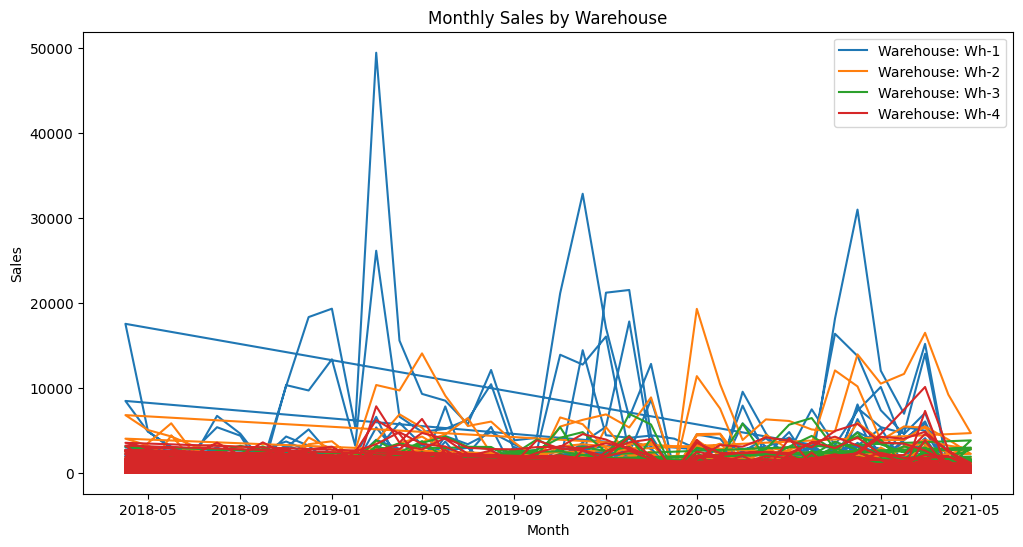

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmode

Forecast results saved as 'Forecast_Results_with_Weather.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

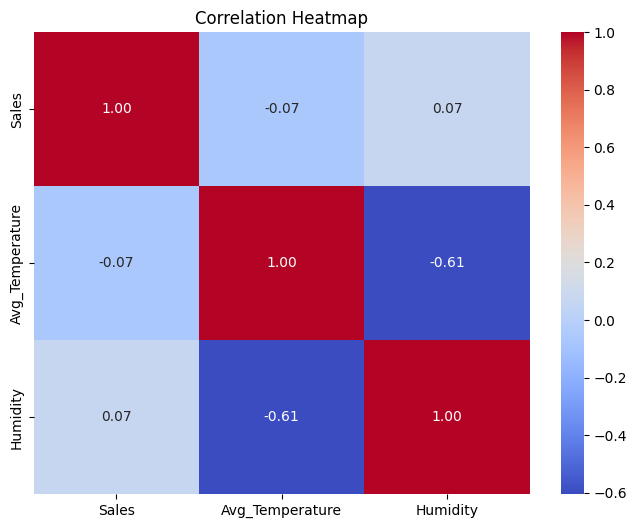

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from google.colab import files
import requests
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Step 1: Upload the dataset
print("Upload your dataset file:")
uploaded = files.upload()

# Load the dataset
file_name = list(uploaded.keys())[0]
data = pd.read_excel(file_name)

# Reshape the data for time series analysis
data = pd.melt(data, id_vars=["Warehouse id", "Region", "SKU id"],
               var_name="Month", value_name="Sales")

# Convert 'Month' to datetime
data['Month'] = pd.to_datetime(data['Month'], format='%b-%y')

# Fill missing values
data['Sales'] = data['Sales'].interpolate(method='linear')

# Step 2: Exploratory Data Analysis (EDA)
print("Dataset Overview:")
print(data.head())
print("\nDataset Information:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())

# Step 3: Feature Engineering
# Create additional features
data['Year'] = data['Month'].dt.year
data['Month_Num'] = data['Month'].dt.month
data['Quarter'] = data['Month'].dt.quarter
data['Is_Holiday'] = data['Month'].dt.month.isin([12, 1])

# Step 4: Data Preprocessing
# Group data by Warehouse id, Region, SKU id, and Month
grouped_data = data.groupby(['Warehouse id', 'Region', 'SKU id', 'Month'])['Sales'].sum().reset_index()

# Visualization of aggregated sales per warehouse
plt.figure(figsize=(12, 6))
for warehouse in grouped_data['Warehouse id'].unique():
    warehouse_data = grouped_data[grouped_data['Warehouse id'] == warehouse]
    plt.plot(warehouse_data['Month'], warehouse_data['Sales'], label=f"Warehouse: {warehouse}")

plt.title("Monthly Sales by Warehouse")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Step 5: Seasonal Decomposition for trend analysis
if ('W1' in grouped_data['Warehouse id'].values) and ('SKU1' in grouped_data['SKU id'].values):
    sample_data = grouped_data[(grouped_data['Warehouse id'] == 'W1') &
                               (grouped_data['SKU id'] == 'SKU1')]

    if len(sample_data) >= 24:  # Ensure minimum data points for decomposition
        decomposition = seasonal_decompose(sample_data['Sales'], model='multiplicative', period=12)
        decomposition.plot()
        plt.tight_layout()
        plt.show()
    else:
        logging.warning("Not enough data points for seasonal decomposition (minimum 24 required). Skipping decomposition.")
else:
    logging.warning("Warehouse 'W1' or SKU 'SKU1' not found in the dataset. Skipping decomposition.")

# Step 6: Time Series Forecasting
forecast_results = []
for (warehouse, region, sku), sku_data in grouped_data.groupby(['Warehouse id', 'Region', 'SKU id']):
    sku_data = sku_data.set_index('Month')

    # Split data into training and testing
    train_data = sku_data.loc[sku_data.index < '2021-05-01', 'Sales']

    # Forecast using SARIMA model
    try:
        if len(train_data) >= 12:
            model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
            forecast = model.forecast(1)
            forecast_results.append({
                'Warehouse id': warehouse,
                'Region': region,
                'SKU id': sku,
                'Jun-21': forecast.values[0]
            })
        else:
            forecast_results.append({
                'Warehouse id': warehouse,
                'Region': region,
                'SKU id': sku,
                'Jun-21': np.nan
            })
    except Exception as e:
        logging.error(f"Error forecasting SKU {sku}: {e}")

# Step 7: Fetch Weather Data
region_to_city = {
    'NORTH': 'Delhi',
    'SOUTH': 'Chennai',
    'EAST': 'Kolkata',
    'WEST': 'Mumbai'
}

def fetch_weather_data(region):
    city = region_to_city.get(region, None)
    if not city:
        return {'City': np.nan, 'Avg_Temperature': np.nan, 'Humidity': np.nan}

    weather_api_key = "931f131dde3f4ae2fcbc3289fc646471"  # Replace with your API key
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city},IN&appid={weather_api_key}&units=metric"

    try:
        response = requests.get(url)
        response_data = response.json()
        if response.status_code == 200:
            return {
                'City': city,
                'Avg_Temperature': response_data['main']['temp'],
                'Humidity': response_data['main']['humidity']
            }
        else:
            return {'City': city, 'Avg_Temperature': np.nan, 'Humidity': np.nan}
    except:
        return {'City': city, 'Avg_Temperature': np.nan, 'Humidity': np.nan}

for result in forecast_results:
    weather_data = fetch_weather_data(result['Region'])
    result.update(weather_data)

# Step 8: Save Results to Excel
forecast_df = pd.DataFrame(forecast_results)
forecast_file = 'Forecast_Results_with_Weather.xlsx'
forecast_df.to_excel(forecast_file, index=False)
print(f"Forecast results saved as '{forecast_file}'")
files.download(forecast_file)

# Step 9: Correlation Analysis
merged_data = pd.merge(grouped_data, forecast_df[['Warehouse id', 'Region', 'SKU id', 'Avg_Temperature', 'Humidity']],
                       on=['Warehouse id', 'Region', 'SKU id'], how='left')
correlation = merged_data[['Sales', 'Avg_Temperature', 'Humidity']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()